<h1 align="center">Introduction to Machine Learning - Course Code: 25737</h1>
<h4 align="center">Instructor: Dr. Amiri</h4>
<h4 align="center">Sharif University of Technology, Spring 2024</h4>
<h4 align="center">Computer Assignment 3</h4>
<h4 align="center">

Question 2

</h4>

# Personal Data

In [ ]:
# Set your student number
student_number = 99101943
Name = 'Matin'
Last_Name = 'Alinejad'

# Rules
- You are not allowed to add or remove cells. You **must use the provided space to write your code**. If you don't follow this rule, **your Practical Assignment won't be graded**.  

- Collaboration and using the internet is allowed, but your code **must be written by yourself**. **Copying code** from each other or from available resources will result in a **zero score for the assignment**.

- You are not allowed to use `torch.nn`, `torch.optim` and any activation function and loss function implemented in torch.

## Question 1) Convolutional Neural Networks ``(50 pt.)``

In this question, you'll be coding up a convolutional neural network from scratch to classify images using PyTorch.  

### Instructions
- Install PyTorch following the instructions [here](https://pytorch.org/).
- Install the [`torchinfo` package](https://github.com/TylerYep/torchinfo) to visualize the network architecture and the number of parameters. The maximum number of parameters you are allowed to use for your network is **100,000**.
- You are required to complete the functions defined in the code blocks following each question. Fill out sections of the code marked `"YOUR CODE HERE"`.
- You're free to add any number of methods within each class.
- You may also add any number of additional code blocks that you deem necessary.

### Data Preparation
In this assignment, we will use the Fashion-MNIST dataset. Fashion-MNIST is a dataset of Zalando's article images—consisting of a training set of 60,000 examples and a test set of 10,000 examples. Each example is a 28x28 grayscale image, associated with a label from 10 classes.  

#### Data

Each image is 28 pixels in height and 28 pixels in width, for a total of 784 pixels in total. Each pixel has a single pixel-value associated with it, indicating the lightness or darkness of that pixel, with higher numbers meaning darker. This pixel-value is an integer between 0 and 255.  

#### Labels

Each training and test example is assigned to one of the following labels:

| Label | Description |
|-------|-------------|
| 0     | T-shirt/top |
| 1     | Trouser     |
| 2     | Pullover    |
| 3     | Dress       |
| 4     | Coat        |
| 5     | Sandal      |
| 6     | Shirt       |
| 7     | Sneaker     |
| 8     | Bag         |
| 9     | Ankle boot  |

Fashion-MNIST is included in the `torchvision` library.

In [ ]:
# Import required packages
from torchvision.datasets import FashionMNIST
from torchvision.transforms import Compose, ToTensor, Normalize
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
# Transform to normalize the data and convert to a tensor
transform = Compose([ToTensor(), Normalize((0.5,), (0.5,))])

# Download the data
dataset = FashionMNIST('MNIST_data/', download = True, train = True, transform = transform)

100%|██████████| 26421880/26421880 [00:01<00:00, 21372369.01it/s]


Extracting MNIST_data/FashionMNIST/raw/train-images-idx3-ubyte.gz to MNIST_data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 350228.40it/s]


Extracting MNIST_data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to MNIST_data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:00<00:00, 6115506.48it/s]


Extracting MNIST_data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to MNIST_data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 15067883.46it/s]

Extracting MNIST_data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to MNIST_data/FashionMNIST/raw



### Data Exploration
Let's take a look at the classes in our dataset.

In [ ]:
print(dataset.classes)

['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


Now, visualize an instance from each class.

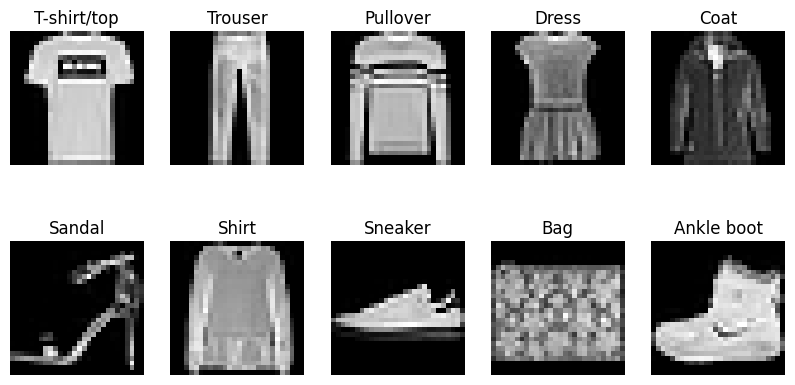

In [ ]:
######################
#   YOUR CODE HERE   #

# Visualize an instance from each class
def visualize_classes(dataset, classes):
    # Dictionary to store an instance of each class
    class_instances = {class_name: None for class_name in classes}

    for image, label in dataset:
        class_name = classes[label]
        if class_instances[class_name] is None:
            class_instances[class_name] = image
        # Break when we have one instance of each class
        if all(value is not None for value in class_instances.values()):
            break

    # Plotting the instances
    plt.figure(figsize=(10, 5))
    for idx, (class_name, image) in enumerate(class_instances.items()):
        plt.subplot(2, 5, idx + 1)
        plt.imshow(image.squeeze(), cmap = 'gray')
        plt.title(class_name)
        plt.axis('off')
    plt.show()

visualize_classes(dataset, dataset.classes)

######################

### Creating Training and Validation Datasets

The `split_indices` function takes in the size of the entire dataset, `n`, the fraction of data to be used as validation set, `val_frac`, and the random seed and returns the indices of the data points to be added to the validation dataset.

In [ ]:
def split_indices(n, val_frac, seed):
    # Determine the size of the validation set
    n_val = int(val_frac * n)
    np.random.seed(seed)
    # Create random permutation between 0 to n - 1
    idxs = np.random.permutation(n)
    # Pick first n_val indices for validation set
    return idxs[n_val:], idxs[:n_val]

In [ ]:
######################
#   YOUR CODE HERE   #
######################
val_frac =  0.2 ## Set the fraction for the validation set
rand_seed =  42 ## Set the random seed

train_indices, val_indices = split_indices(len(dataset), val_frac, rand_seed)
print("number of samples in training set: {}".format(len(train_indices)))
print("number of samples in validation set: {}".format(len(val_indices)))

number of samples in training set: 48000
number of samples in validation set: 12000


Next, we make use of the built-in dataloaders in PyTorch to create iterables of our our training and validation sets. This helps in avoiding fitting the whole dataset into memory and only loads a batch of the data that we can decide.

In [ ]:
# Import required packages
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data.dataloader import DataLoader

In [ ]:
######################
#   YOUR CODE HERE   #
######################
batch_size = 64 ## Set the batch size

# Training sampler and data loader
train_sampler = SubsetRandomSampler(train_indices)
train_dl = DataLoader(dataset,
                     batch_size,
                     sampler = train_sampler)

# Validation sampler and data loader
val_sampler = SubsetRandomSampler(val_indices)
val_dl = DataLoader(dataset,
                   batch_size,
                   sampler = val_sampler)


# Print to check if dataloaders are created correctly
print(f"Number of batches in training set: {len(train_dl)}")
print(f"Number of batches in validation set: {len(val_dl)}")

Number of batches in training set: 750
Number of batches in validation set: 188


Plot images in a sample batch of data.

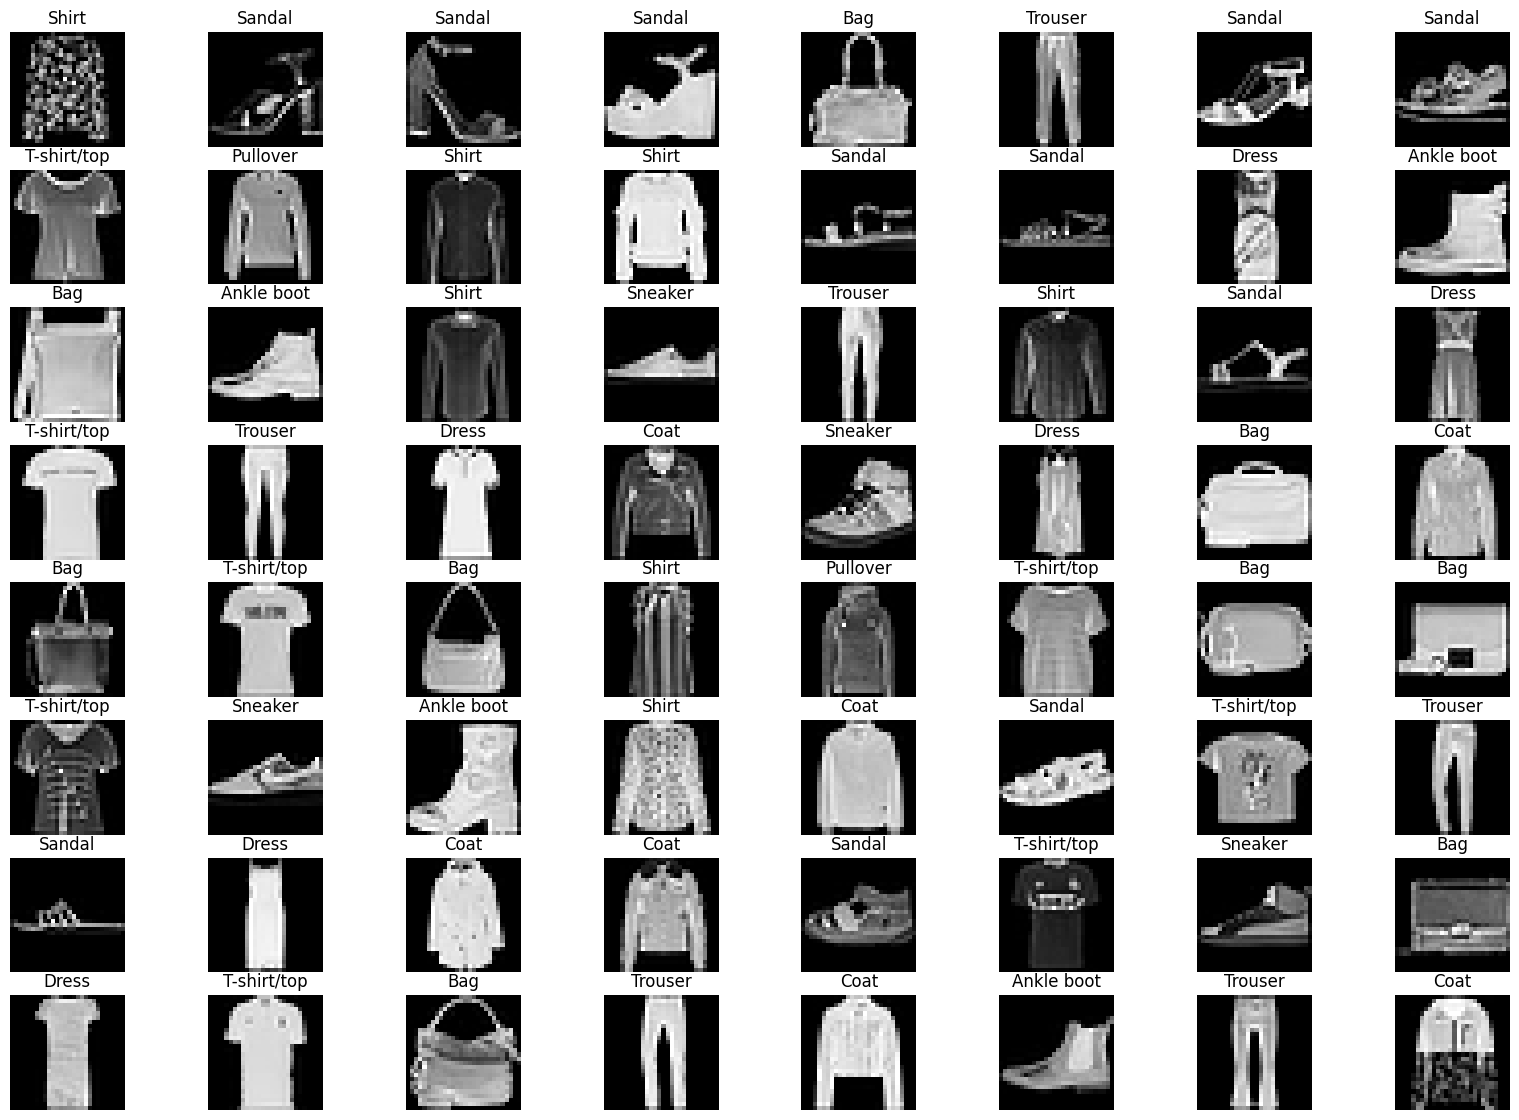

In [ ]:
######################
#   YOUR CODE HERE   #

# Function to plot images in a sample batch of data
def plot_sample_batch(data_loader, classes, batch_size):
    # Get a single batch from the data loader
    data_iter = iter(data_loader)
    images, labels = next(data_iter)

    # Plot the images and labels
    plt.figure(figsize = (20, 14))
    for idx in range(batch_size):
        plt.subplot(8, 8, idx + 1)
        plt.imshow(images[idx].squeeze(), cmap = 'gray')
        plt.title(classes[labels[idx].item()])
        plt.axis('off')
    plt.show()

# Plot images in a sample batch from the training set
plot_sample_batch(train_dl, dataset.classes, batch_size = 64)

######################

### Building the Model
Create your model by defining the network architecture in the `ImageClassifierNet` class.<br>
**NOTE:** The number of parameters in your network must be $\leq$ 100,000.

In [ ]:
!pip install torchinfo

# Import required packages
import torch
from torch import optim
import torch.nn as nn
import torch.nn.functional as F
from torchinfo import summary

In [ ]:
class ImageClassifierNet(nn.Module):
    def __init__(self, n_channels=3):
        super(ImageClassifierNet, self).__init__()
        ######################
        #   YOUR CODE HERE   #

        self.conv1 = nn.Conv2d(1, 12, kernel_size = 3, padding = 1)  # Input channels: 1, Output channels: 12
        self.conv2 = nn.Conv2d(12, 24, kernel_size = 3, padding = 1)  # Input channels: 12, Output channels: 24
        self.conv3 = nn.Conv2d(24, 48, kernel_size = 3, padding = 1)  # Input channels: 24, Output channels: 48
        self.pool = nn.MaxPool2d(kernel_size = 2, stride = 2)
        self.fc1 = nn.Linear(48 * 3 * 3, 64)  # Fully connected layer 1
        self.fc2 = nn.Linear(64, 32)  # Fully connected layer 2
        self.fc3 = nn.Linear(32, 10)  # Fully connected layer 3 (output layer)
        ######################

    def forward(self, X):
        ######################
        #   YOUR CODE HERE   #

        X = self.pool(F.relu(self.conv1(X)))
        X = self.pool(F.relu(self.conv2(X)))
        X = self.pool(F.relu(self.conv3(X)))
        X = X.view(-1, 48 * 3 * 3)  # Flatten the tensor
        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
        X = self.fc3(X)
        return X
        ######################


In [ ]:
model = ImageClassifierNet()

The following code block prints your network architecture. It also shows the total number of parameters in your network (see `Total params`).  

**NOTE: The total number of parameters in your model should be <= 100,000.**

In [ ]:
print(summary(model, input_size = (64, 1, 28, 28)))

Layer (type:depth-idx)                   Output Shape              Param #
ImageClassifierNet                       [64, 10]                  --
├─Conv2d: 1-1                            [64, 12, 28, 28]          120
├─MaxPool2d: 1-2                         [64, 12, 14, 14]          --
├─Conv2d: 1-3                            [64, 24, 14, 14]          2,616
├─MaxPool2d: 1-4                         [64, 24, 7, 7]            --
├─Conv2d: 1-5                            [64, 48, 7, 7]            10,416
├─MaxPool2d: 1-6                         [64, 48, 3, 3]            --
├─Linear: 1-7                            [64, 64]                  27,712
├─Linear: 1-8                            [64, 32]                  2,080
├─Linear: 1-9                            [64, 10]                  330
Total params: 43,274
Trainable params: 43,274
Non-trainable params: 0
Total mult-adds (M): 73.43
Input size (MB): 0.20
Forward/backward pass size (MB): 8.48
Params size (MB): 0.17
Estimated Total Size (MB): 8.

### Train the model
Complete the `train_model` function to train your model on a dataset. Tune your network architecture and hyperparameters on the validation set.

In [ ]:
def train_model(n_epochs, model, train_dl, val_dl, loss_fn, opt_fn, lr):
    """
    Trains the model on a dataset.

    Args:
        n_epochs: number of epochs
        model: ImageClassifierNet object
        train_dl: training dataloader
        val_dl: validation dataloader
        loss_fn: the loss function
        opt_fn: the optimizer
        lr: learning rate

    Returns:
        The trained model.
        A tuple of (model, train_losses, val_losses, train_accuracies, val_accuracies)
    """
    # Record these values the end of each epoch
    train_losses, val_losses, train_accuracies, val_accuracies = [], [], [], []

    ######################
    #   YOUR CODE HERE   #

    # Initialize the optimizer
    optimizer = opt_fn(model.parameters(), lr=lr)

    # Training loop
    for epoch in range(n_epochs):
        model.train()  # Set model to training mode
        train_loss, correct_train, total_train = 0.0, 0, 0

        for images, labels in train_dl:
            optimizer.zero_grad()  # Zero the gradients
            outputs = model(images)  # Forward pass
            loss = loss_fn(outputs, labels)  # Compute the loss
            loss.backward()  # Backward pass
            optimizer.step()  # Update the parameters

            train_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        train_losses.append(train_loss / total_train)
        train_accuracies.append(correct_train / total_train)

        # Validation loop
        model.eval()  # Set model to evaluation mode
        val_loss, correct_val, total_val = 0.0, 0, 0

        with torch.no_grad():
            for images, labels in val_dl:
                outputs = model(images)
                loss = loss_fn(outputs, labels)
                val_loss += loss.item() * images.size(0)
                _, predicted = torch.max(outputs, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()

        val_losses.append(val_loss / total_val)
        val_accuracies.append(correct_val / total_val)

        print(f'Epoch {epoch + 1}/{n_epochs}, Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}, Train Acc: {train_accuracies[-1]:.4f}, Val Acc: {val_accuracies[-1]:.4f}')

    ######################

    return model, train_losses, val_losses, train_accuracies, val_accuracies

In [ ]:
######################
#   YOUR CODE HERE   #

# Define parameters
num_epochs = 10  # Number of training epochs
loss_fn = nn.CrossEntropyLoss()  # Define the loss function
opt_fn = optim.Adam  # Select an optimizer
lr = 0.001  # Set the learning rate
######################


In [ ]:
model, train_losses, val_losses, train_accuracies, val_accuracies = train_model(num_epochs, model, train_dl, val_dl, loss_fn, opt_fn, lr)

Epoch 1/10, Train Loss: 0.6731, Val Loss: 0.4424, Train Acc: 0.7534, Val Acc: 0.8426
Epoch 2/10, Train Loss: 0.3915, Val Loss: 0.3753, Train Acc: 0.8574, Val Acc: 0.8643
Epoch 3/10, Train Loss: 0.3335, Val Loss: 0.3428, Train Acc: 0.8768, Val Acc: 0.8731
Epoch 4/10, Train Loss: 0.3020, Val Loss: 0.2982, Train Acc: 0.8886, Val Acc: 0.8914
Epoch 5/10, Train Loss: 0.2791, Val Loss: 0.2966, Train Acc: 0.8965, Val Acc: 0.8953
Epoch 6/10, Train Loss: 0.2587, Val Loss: 0.2755, Train Acc: 0.9041, Val Acc: 0.9012
Epoch 7/10, Train Loss: 0.2427, Val Loss: 0.2685, Train Acc: 0.9093, Val Acc: 0.9020
Epoch 8/10, Train Loss: 0.2300, Val Loss: 0.2759, Train Acc: 0.9148, Val Acc: 0.8995
Epoch 9/10, Train Loss: 0.2197, Val Loss: 0.2510, Train Acc: 0.9183, Val Acc: 0.9076
Epoch 10/10, Train Loss: 0.2097, Val Loss: 0.2488, Train Acc: 0.9213, Val Acc: 0.9101


### Plot loss and accuracy

In [ ]:
def plot_accuracy(train_accuracies, val_accuracies):
    """Plot accuracies"""
    plt.plot(train_accuracies, "-x")
    plt.plot(val_accuracies, "-o")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend(["Training", "Validation"])
    plt.title("Accuracy vs. No. of epochs")

def plot_losses(train_losses, val_losses):
    """Plot losses"""
    plt.plot(train_losses, "-x")
    plt.plot(val_losses, "-o")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(["Training", "Validation"])
    plt.title("Loss vs. No. of Epochs")

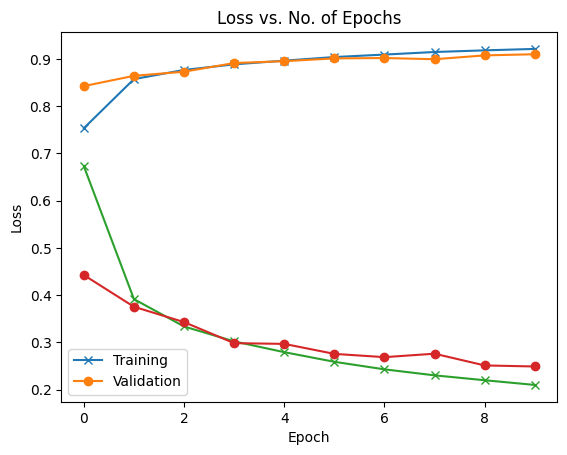

In [ ]:
plot_accuracy(train_accuracies, val_accuracies)
plot_losses(train_losses, val_losses)

### Train a model on the entire dataset

In [ ]:
indices, _ = split_indices(len(dataset), 0, rand_seed)

sampler = SubsetRandomSampler(indices)
dl = DataLoader(dataset, batch_size, sampler = sampler)

In [ ]:
######################
#   YOUR CODE HERE   #
def train_model(n_epochs, model, train_dl, val_dl, loss_fn, opt_fn, lr):
    """
    Trains the model on a dataset.

    Args:
        n_epochs: number of epochs
        model: ImageClassifierNet object
        train_dl: training dataloader
        val_dl: validation dataloader
        loss_fn: the loss function
        opt_fn: the optimizer
        lr: learning rate

    Returns:
        The trained model.
        A tuple of (model, train_losses, val_losses, train_accuracies, val_accuracies)
    """
    # Record these values the end of each epoch
    train_losses, val_losses, train_accuracies, val_accuracies = [], [], [], []

    # Initialize the optimizer
    optimizer = opt_fn(model.parameters(), lr=lr)

    # Training loop
    for epoch in range(n_epochs):
        model.train()  # Set model to training mode
        train_loss, correct_train, total_train = 0.0, 0, 0

        for images, labels in train_dl:
            optimizer.zero_grad()  # Zero the gradients
            outputs = model(images)  # Forward pass
            loss = loss_fn(outputs, labels)  # Compute the loss
            loss.backward()  # Backward pass
            optimizer.step()  # Update the parameters

            train_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        train_losses.append(train_loss / total_train)
        train_accuracies.append(correct_train / total_train)

        # Validation loop (only if val_dl is not empty)
        if val_dl:
            model.eval()  # Set model to evaluation mode
            val_loss, correct_val, total_val = 0.0, 0, 0

            with torch.no_grad():
                for images, labels in val_dl:
                    outputs = model(images)
                    loss = loss_fn(outputs, labels)
                    val_loss += loss.item() * images.size(0)
                    _, predicted = torch.max(outputs, 1)
                    total_val += labels.size(0)
                    correct_val += (predicted == labels).sum().item()

            val_losses.append(val_loss / total_val)
            val_accuracies.append(correct_val / total_val)

            print(f'Epoch {epoch + 1}/{n_epochs}, Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}, Train Acc: {train_accuracies[-1]:.4f}, Val Acc: {val_accuracies[-1]:.4f}')
        else:
            print(f'Epoch {epoch + 1}/{n_epochs}, Train Loss: {train_losses[-1]:.4f}, Train Acc: {train_accuracies[-1]:.4f}')

    return model, train_losses, val_losses, train_accuracies, val_accuracies

# Define parameters for training on the entire dataset
num_epochs = 10  # Max number of training epochs
lr = 0.001  # Set the learning rate
######################

In [ ]:
# Define the model, loss function, and optimizer
model = ImageClassifierNet()  # Assuming ImageClassifierNet is already defined
loss_fn = nn.CrossEntropyLoss()  # Define the loss function
opt_fn = optim.Adam  # Select an optimizer

# Train the model on the entire dataset
model, _, _, _, _ = train_model(num_epochs, model, dl, None, loss_fn, opt_fn, lr)

Epoch 1/10, Train Loss: 0.6213, Train Acc: 0.7689
Epoch 2/10, Train Loss: 0.3693, Train Acc: 0.8652
Epoch 3/10, Train Loss: 0.3141, Train Acc: 0.8858
Epoch 4/10, Train Loss: 0.2807, Train Acc: 0.8974
Epoch 5/10, Train Loss: 0.2571, Train Acc: 0.9058
Epoch 6/10, Train Loss: 0.2404, Train Acc: 0.9115
Epoch 7/10, Train Loss: 0.2258, Train Acc: 0.9181
Epoch 8/10, Train Loss: 0.2164, Train Acc: 0.9202
Epoch 9/10, Train Loss: 0.2021, Train Acc: 0.9251
Epoch 10/10, Train Loss: 0.1946, Train Acc: 0.9284


### Check Predictions
Now, you should evaluate your model on dataset. Specifically, you should calculate the class probabilities for each image, and then visualize these probabilities along with the image itself. Please include a function `view_prediction` in your code that takes an image, its label, the calculated probabilities, and the list of class names as input, and plots the image along with the probabilities.

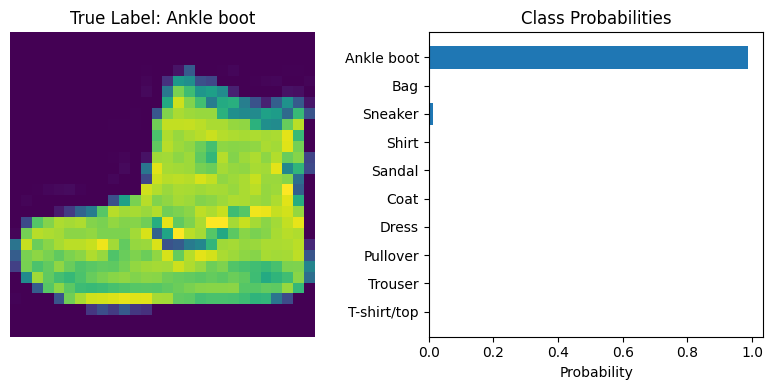

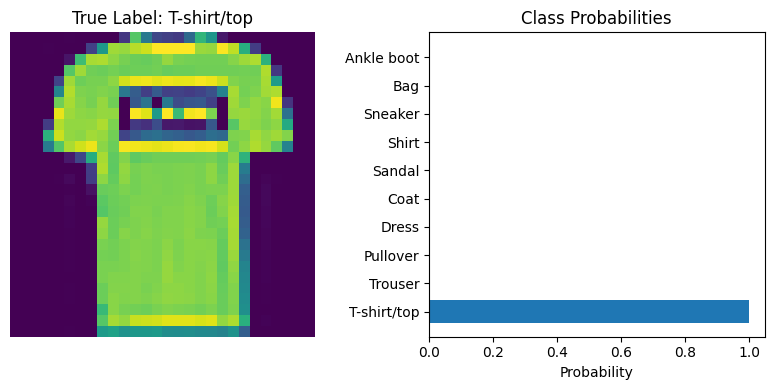

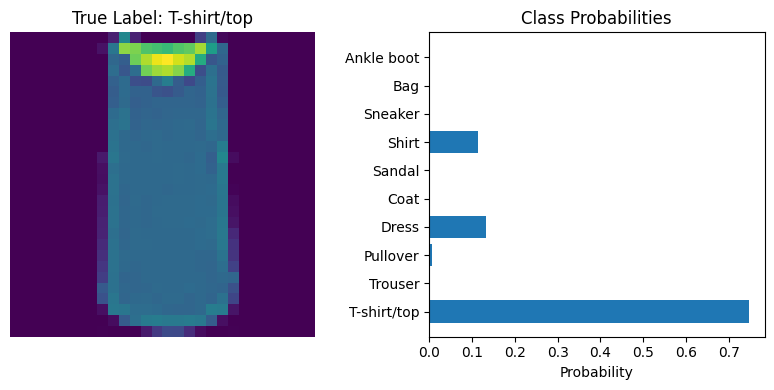

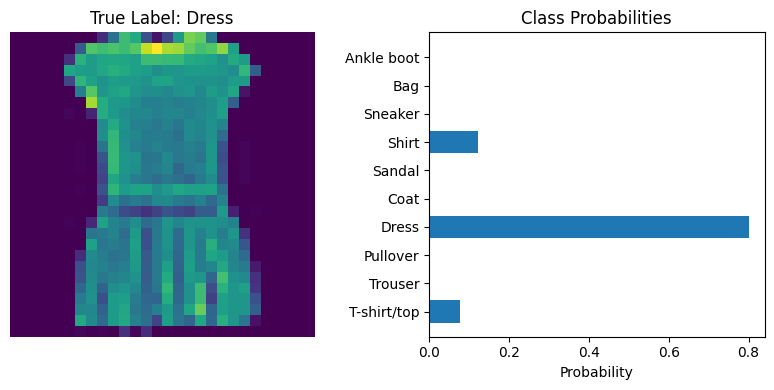

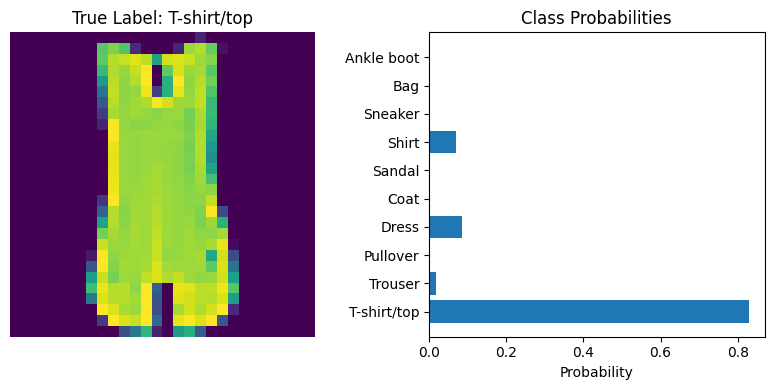

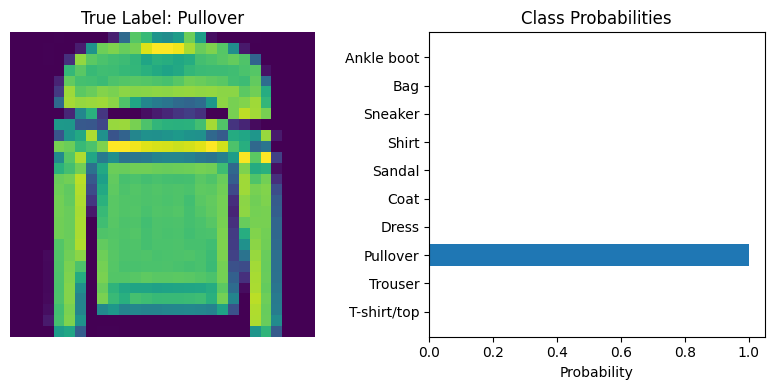

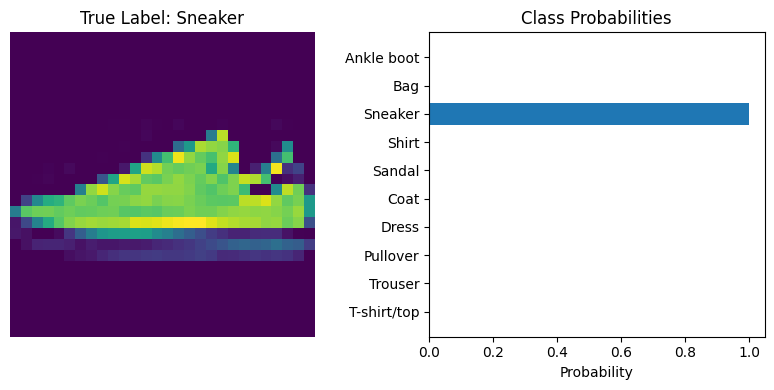

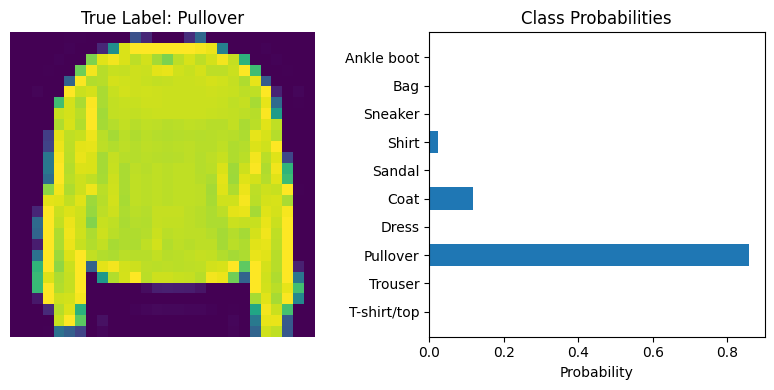

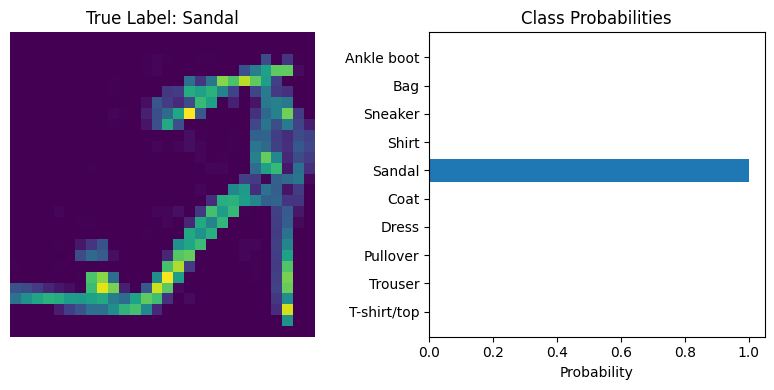

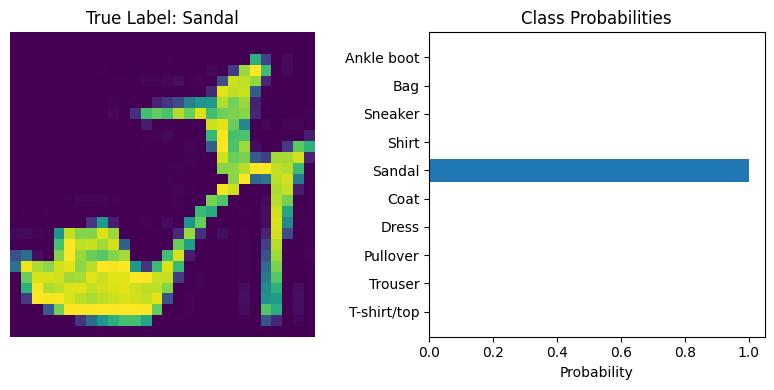

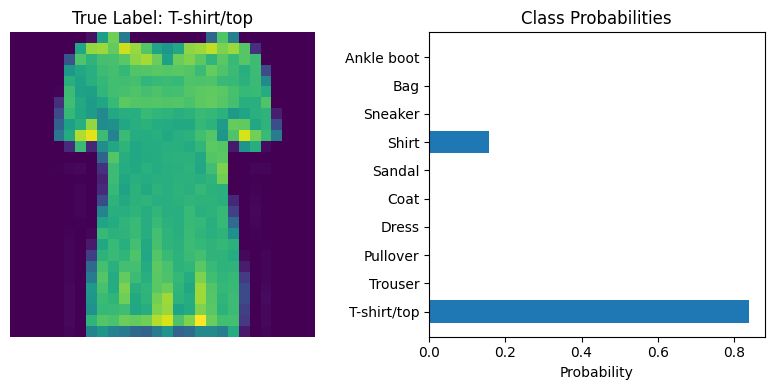

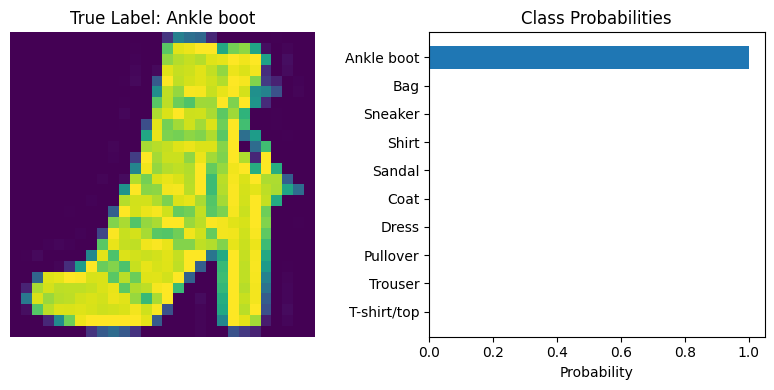

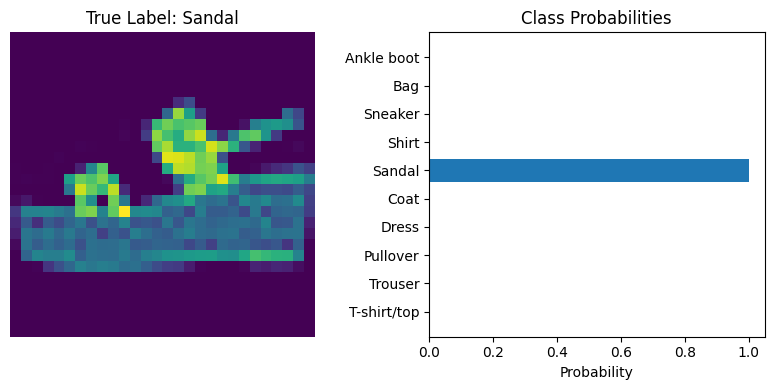

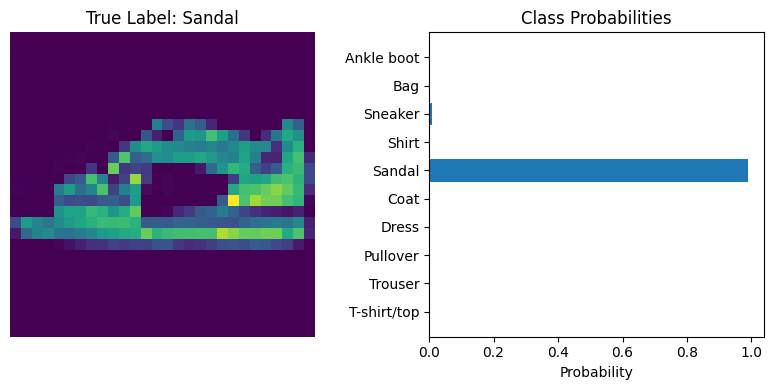

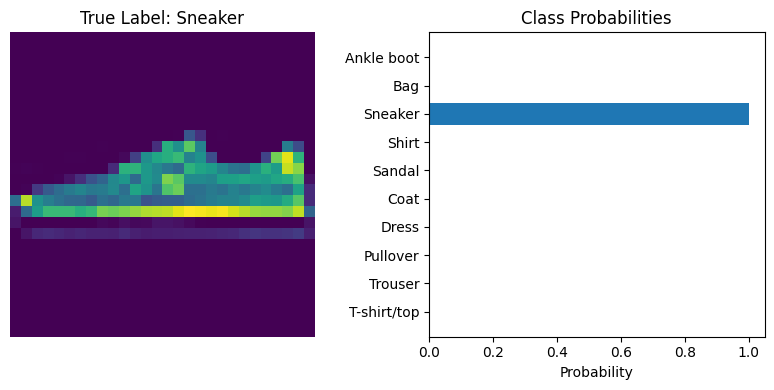

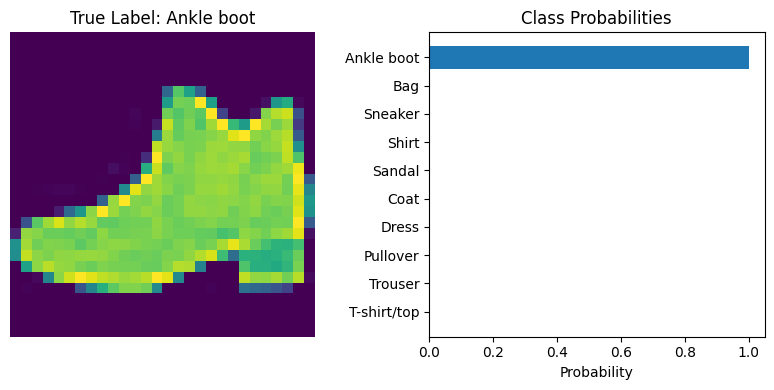

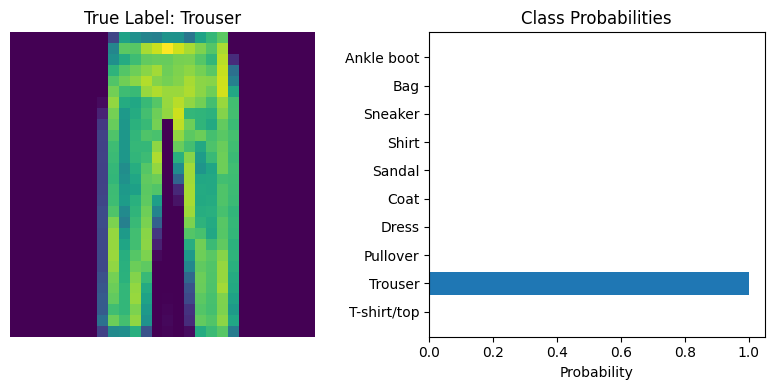

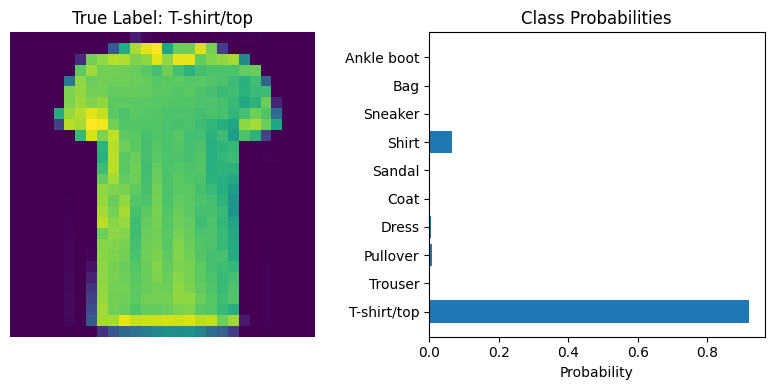

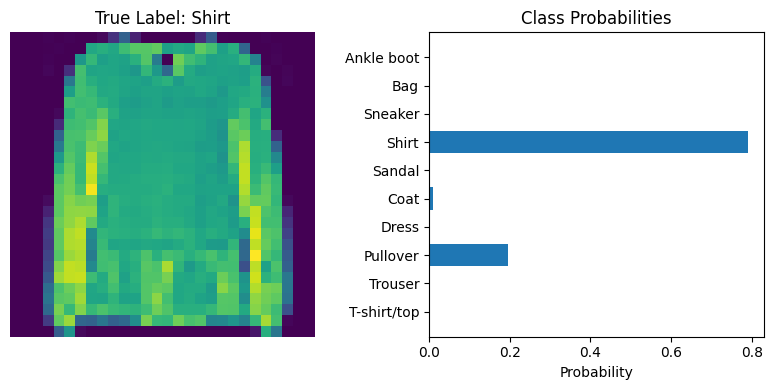

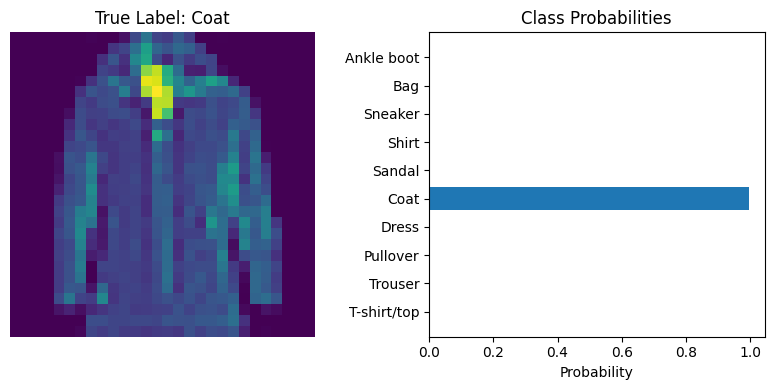

In [45]:
######################
#   YOUR CODE HERE   #

def view_prediction(image, label, probabilities, class_names):
    """
    Visualizes the image and the class probabilities.

    Args:
        image: the input image
        label: the true label of the image
        probabilities: the class probabilities
        class_names: the list of class names
    """
    # Convert image to numpy for plotting
    image = image.numpy().transpose((1, 2, 0))

    # Plot the image
    plt.figure(figsize = (8, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.title(f'True Label: {class_names[label]}')
    plt.axis('off')

    # Plot the class probabilities
    plt.subplot(1, 2, 2)
    y_pos = np.arange(len(class_names))
    plt.barh(y_pos, probabilities, align = 'center')
    plt.yticks(y_pos, class_names)
    plt.xlabel('Probability')
    plt.title('Class Probabilities')

    plt.tight_layout()
    plt.show()

def evaluate_model(model, dataset, class_names):
    """
    Evaluates the model on the dataset and visualizes predictions.

    Args:
        model: the trained model
        dataset: the dataset to evaluate
        class_names: the list of class names
    """
    model.eval()  # Set the model to evaluation mode

    for i in range(len(dataset)):
        image, label = dataset[i]
        with torch.no_grad():
            output = model(image.unsqueeze(0))
            probabilities = F.softmax(output, dim = 1).squeeze().numpy()

        view_prediction(image, label, probabilities, class_names)

        if i == 19: # It's not essential. It's just for see quality of our detecting algorithm on number of classes.
          break



# Assuming the dataset, model, and class_names are already defined
evaluate_model(model, dataset, dataset.classes)
######################

### Save the model

In [46]:
torch.save(model, 'model')

### Calculate accuracy on the test set

In [47]:
test_dataset = FashionMNIST('MNIST_data/', download = True, train = False, transform = transform)
test_dl = DataLoader(test_dataset, batch_size)

In [48]:
def evaluate(model, test_dl):
    """
    Evaluates your model on the test data.

    Args:
        model: ImageClassifierNet object
        test_dl: test dataloader

    Returns:
        Test accuracy.
    """
    ######################
    #   YOUR CODE HERE   #

    model.eval()  # Set the model to evaluation mode
    correct, total = 0, 0

    with torch.no_grad():
        for images, labels in test_dl:
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = correct / total
    return accuracy
    ######################

In [49]:
print("Test Accuracy = {:.4f}".format(evaluate(model, test_dl)))

Test Accuracy = 0.9050
